# Esercizio 1
Lo scopo di questo esercizio è creare un generatore di numeri casuali distribuiti secondo la distribuzione di Breit-Wigner. In primo luogo è necessario un generatore di numeri casuali uniformi tra 0 e 1, successivamente si utilizza il metodo della funzione inversa per generare campioni secondo la distribuzione richiesta.

## Subtract-with-borrow generator

Il generatore di numeri casuali uniformi scelto è del tipo *fibonacci ritardato*, un generatore lineare congruente generalizzato. 
E' molto veloce perchè utilizza solamente operazioni di sottrazione e modulo e permette di ottenere periodi molto più lunghi di un linear congruential generator. L'unico svantaggio è che deve mantenere in memoria un buffer contenente gli ultimi R numeri generati. 

Siano R, S due interi con R > S > 0. Sia B la base. Il generatore si basa sulla formula ricorsiva

\begin{equation}
x(i)  = ( x(i-S) - x(i-R) - c(i-1) ) mod B
\end{equation}

$c(i)$ è chiamato *borrow* e vale:
\begin{equation}
c(i)  = \begin{cases} 
        1 \qquad \text{se}\; x(i-S) - x(i-R) - c(i-1)) < 0 \\ 0\qquad \text{altrimenti}
\end{cases}
\end{equation}

Il generatore quindi mantiene in memoria un buffer di R numeri che deve essere fornito come **seed** all'inzio della generazione. Nel nostro caso utilizziamo la base $2^{64}$, $R = 34$, $S = 19$.

La perioditicità massima è $M-1$ con $$M = b^R -b^S -1 $$ e si ottiene quando M è primo e b è una radice primitiva di modulo M.

In [1]:
import ROOT as R
R.gStyle.SetOptFit(1111)
#R.enableJSVis()
from array import array
import numpy as np
%load_ext cython

Welcome to JupyROOT 6.12/04


In [2]:
%%cpp
vector<unsigned long> * buffer;
int ci = 0;
int R, S;

In [3]:
%%cpp -d
bool initialize_generator(int r, int s, vector<unsigned long>& seed){
    if (seed.size() < r ) {
        cout << "The side must be of size R" << endl;
        return false;
    }else{
        buffer = &seed;
        R = r;
        S = s;
        return true;
    }
}

### Algoritmo di generazione del successivo numero casuale
La funzione next fornisce il successivo numero della sequenza e lo salva in fondo al buffer che viene scalato in avanti di un elemento. Si calcola anche il parametri $c(i)$ da utilizzare nel prossimo step. 

In [4]:
%%cpp -d
unsigned long next(){
    unsigned long x_i_s = buffer->at(R-S);
    unsigned long x_i_r = buffer->at(0);
    long sum = x_i_s - x_i_r - ci;
    ci = (  (sum<0) ? 1 : 0 );
    // We have to do the modulus 64 bit
    unsigned long new_x = sum & 0xffffffffffffffff;
    // Move the buffer
    buffer->push_back(new_x);
    buffer->erase(buffer->begin());
    return new_x ;
}

### Seed
Come seed si utilizza un vettore di unsigned long generato casualmente con le librerie standard di Python e hardcodato per la riproducibilità dei calcoli seguenti. Il seed viene utilizzato assieme ai parametri scleti per inizializzare il generatore. 

In [5]:
seed = [5476539507261238750, 14529639423954617551, 12329190370034073525, 9156205971367159455, 
        1006696354915624081, 11756690824174816702, 11050414037116895503, 6338068784802362828, 
        13438679830617424944, 6332419665641958099, 1327643120321859445, 13854758379671069208, 
        16701929990922112145, 12417757074029179162, 370380452438106923, 9692322003591594913, 
        2144769984428991825, 7466733547408371628, 7228927142930037033, 9524035634545938709, 
        1694204564084735219, 3647148392607882053, 759802613314802600, 1886526891130422985, 
        9385809177362151940, 4202312710834000028, 3525944780100075070, 14103117208480948891, 
        6282950788341163038, 4418405359885357944, 9416408316145340942, 8259437781508711525, 
        13528031637756382284, 981402858317976209]
seed_vector = R.vector("unsigned long")()
for i in range(34):
    seed_vector.push_back(seed[i])

In [6]:
R.initialize_generator(34, 19, seed_vector)

True

### Generazione di numeri distribuiti uniformement
Questa funzione genera una sequenza di l numeri distribuiti in modo uniforme nell'intervallo [0,1] e la restituisce in formato numpy array.

In [7]:
ULONGMAX = 18446744073709551615.
def generate_sequence(l, width=1, offset=0):
    a = np.zeros(l, dtype=np.float)
    for i in range(l):
        a[i] = R.next()
    a = (a /  ULONGMAX) *width + offset
    return a

In [8]:
%time sequence = generate_sequence(1000000, 10)

CPU times: user 865 ms, sys: 153 ms, total: 1.02 s
Wall time: 1.02 s


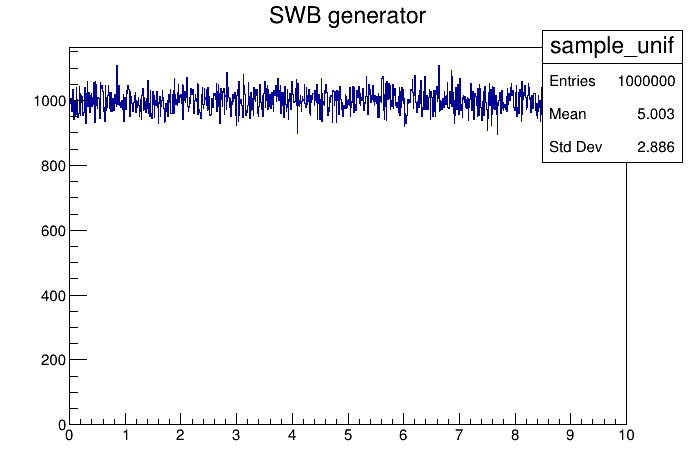

In [9]:
c = R.TCanvas("c")
h = R.TH1D("sample_unif", "SWB generator", 1000, 0,10)
for i in sequence:
    h.Fill(i)
h.SetMinimum(0)
h.Draw()
c.Draw()

## Test di casualità
Un generatore di numeri casuali deve essere sottoposto a diversi test il cui obiettivo è quello di evidenziare possibili non uniformità del generatore che possono introdurre errori sistematici nei calcoli che lo utilizzano. 

### Il test del parcheggio
Il test consiste nel tentare di parcheggiare della macchine in un quadrato 100x100 senza sovrapposizioni. Si procede per tentativi: ogni volta si genera una coppia di coordinate casuali e controlla la distanza della macchina dalle macchine già parcheggiate. Nel caso la distanza sia maggiore di 1 la macchina viene correttamente parcheggiata. 
La distribuzione del numero di parcheggi riusciti su 12000 tentativi deve essere gaussiana  con media 3523 e sigma 21.9 se il generatore di numeri casuali è ideale. 

Prima di tutto serve una funzione per creare 12000 coordinate x, y distribuite da 0 a 100

In [11]:
def get_coordinates(n):
    x = generate_sequence(n, 100)
    y = generate_sequence(n, 100)
    return np.vstack((x,y)).T

In [13]:
results = []

Si cicla su 12000 coordinate e si conteggia il numero di parcheggi riusciti

In [14]:
for i in range(1000):
    parked = np.array([[0.0,0.0]])
    j= 0
    for x, y in get_coordinates(12000):
        pos = np.array([[x,y]])
        if j == 0:
            parked = pos
            j+=1
            continue
        crash = False
        #controlla che il minimo dei massimi delle distanze sia maggiore di 1
        if np.min(np.amax(np.abs(parked - pos), axis=1)) > 1:
            parked = np.append(parked, pos, axis= 0)
        j+=1
    #save the result
    results.append(len(parked))

parked 3553
parked 3515
parked 3554
parked 3532
parked 3555
parked 3550
parked 3525
parked 3503
parked 3554
parked 3507
parked 3509
parked 3543
parked 3495
parked 3534
parked 3514
parked 3520
parked 3509
parked 3496
parked 3508
parked 3533
parked 3516
parked 3504
parked 3552
parked 3579
parked 3524
parked 3529
parked 3554
parked 3543
parked 3537
parked 3553
parked 3508
parked 3495
parked 3553
parked 3539
parked 3533
parked 3536
parked 3534
parked 3569
parked 3516
parked 3557
parked 3486
parked 3526
parked 3538
parked 3500
parked 3506
parked 3497
parked 3532
parked 3526
parked 3504
parked 3546
parked 3472
parked 3548
parked 3504
parked 3509
parked 3490
parked 3561
parked 3526
parked 3488
parked 3544
parked 3505
parked 3565
parked 3479
parked 3581
parked 3531
parked 3515
parked 3518
parked 3530
parked 3505
parked 3550
parked 3537
parked 3516
parked 3570
parked 3524
parked 3546
parked 3490
parked 3524
parked 3523
parked 3559
parked 3523
parked 3531
parked 3513
parked 3528
parked 3533
park

Tutti i test sono salvati in un TFile

In [16]:
file_tests = R.TFile("test_random_generator.root", "UPDATE")

In [17]:
c_test_park = R.TCanvas("c_parking_test")
h_test_park = R.TH1D("test_parking","Parking slot test", 50, 3430,3630)
for i in results:
    h_test_park.Fill(i)
h_test_park.Fit("gaus")
h_test_park.Draw()
c_test_park.Draw()
h_test_park.Write()

1998

 FCN=19.3025 FROM MIGRAD    STATUS=CONVERGED      56 CALLS          57 TOTAL
                     EDM=1.16645e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.23713e+01   2.83395e+00   5.08504e-03   1.50475e-05
   2  Mean         3.52387e+03   7.06465e-01   1.68031e-03  -5.14490e-05
   3  Sigma        2.17218e+01   5.09395e-01   1.40245e-05  -1.50888e-02


La distribuzione dei risultati ottenuta è compatibile con lo standard. 

Media 3524 +- 0.41 (invece che 3523)
Sigma 21.88 +- 0.29 (attesa 21.9)

In [129]:
file_tests.Close()

### Test degli spazi tra i compleanni
Si generano $m = 2^9$ compleanni in un anno di $n = 2^{24}$ giorni e si contano i giorni tra i compleanni successivi. 
Si estrae J, il numero di valori che appare più di una volta. J deve essere distribuito in modo Poissoniano con $\lambda = \frac{m^3}{4n}$ in questo caso $\lambda = 2$

In [10]:
import pandas as pd
results = []

def generate_birthdays(m,n):
    b = np.sort(np.round(generate_sequence(m, n)))
    diff = np.roll(b,-1) -b 
    s = pd.Series(diff)
    return s[s.duplicated()].size

 FCN=19.9587 FROM MIGRAD    STATUS=CONVERGED      67 CALLS          68 TOTAL
                     EDM=4.97945e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.62283e+00   2.74536e-02   8.57417e-05   8.05934e-05
   2  p1           5.03748e+03   7.12603e+01   2.22535e-01  -3.70382e-09
                               ERR DEF= 0.5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_birthdays_test
Warning in <TROOT::Append>: Replacing existing TH1: test_birthdays (Potential memory leak).


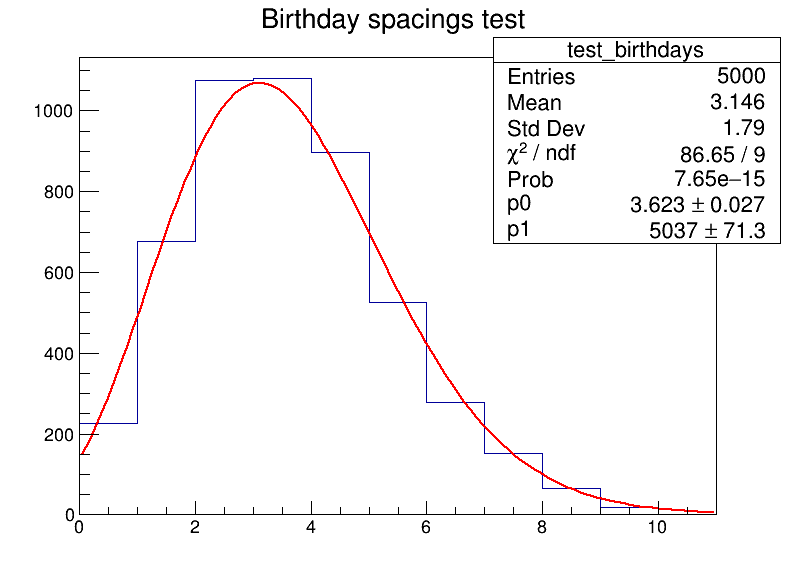

In [14]:
for i in range(5000):
    results.append(generate_birthdays(512, 16777216))

c_test_birthday = R.TCanvas("c_birthdays_test", "", 800, 600)
h_test_birthday = R.TH1D("test_birthdays","Birthday spacings test", 11, 0,11)
for i in results:
    h_test_birthday.Fill(i)
f = R.TF1("poisson","[1]*TMath::Poisson(x[0],[0]);", 0, 11);
f.SetParameter(0, 2)
f.SetParameter(1, 1000)

h_test_birthday.Fit(f, "L")
h_test_birthday.Draw()
c_test_birthday.Draw()

Dal fit dei risultati ottenuti con una distribuzione di Poisson non si ottiene $\lambda=2$, il test è quindi fallito dal generatore.

# Generazione distribuzione di Cauchy
Utilizzando il generatore uniforme studiato si genera un sample di numeri distribuiti secondo la distribuzione di Cauchy grazie al metodo della funzione inversa. 

La pdf di Cauchy è definita come
\begin{equation}
f(x; x_0,\gamma) = \frac{1}{\pi\gamma \left[1 + \left(\frac{x - x_0}{\gamma}\right)^2\right]} = { 1 \over \pi \gamma } \left[ { \gamma^2 \over (x - x_0)^2 + \gamma^2  } \right],
\end{equation}
La sua cdf invece è:
\begin{equation}
F(x; x_0,\gamma)=\frac{1}{\pi} \arctan\left(\frac{x-x_0}{\gamma}\right)+\frac{1}{2}
\end{equation}

Generando numeri causali $ u \in [0,1]$ e inserendoli nella funzione cdf inversa si ottengono numeri distribuiti secondo la pdf richiesta $ x = F^{-1}(u) $.
\begin{equation}
F^{1}(u) = \tan\left(\pi \left(u - \frac{1}{1}\right)\right)
\end{equation}

In [13]:
def inverse(u):
    return np.tan(np.pi * (u - 0.5))

#Vettorizzazione della funzione grazie a numpy
vectorized_inverse = np.vectorize(inverse)

In [14]:
samples = generate_sequence(100000, 1)
cauchy = vectorized_inverse(samples)

In [16]:
c_cauchy = R.TCanvas("c_cauchy")
h_cauchy = R.TH1D("cauchy","Breit-Wigner distribution", 100,-10, 10)
for i in cauchy:
    h_cauchy.Fill(i)
h_cauchy.Draw()
c_cauchy.Draw()
h_cauchy.Write()

0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_cauchy
Warning in <TROOT::Append>: Replacing existing TH1: cauchy (Potential memory leak).
Error in <TROOT::WriteTObject>: The current directory (PyROOT) is not associated with a file. The object (cauchy) has not been written.


# 2D distribution of SWB and TRandom3 generator

## Save the Root file with all the graphs

In [30]:
file_tests.Close()

In [22]:
c_coord = R.TCanvas("c_parking_test_loc", "test",1000, 600)
c_coord.Divide(2,1)
c_coord.cd(1)
coo1 = get_coordinates(12000).T
g1 = R.TGraph(12000, coo1[0], coo1[1])
g1.Draw("P")
g1.SetTitle("SWB")
c_coord.cd(2)
coo2 = get_coordinates_trandom3(12000).T
g2 = R.TGraph(12000, coo2[0], coo2[1])
g2.Draw("P")
g2.SetTitle("ROOT Mersenne Twister")
c_coord.Draw()
c_coord.Write()

327519

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_parking_test_loc
